In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
pip install dash

  Using cached dash-2.18.2-py3-none-any.whl.metadata (10 kB)
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
Using cached dash-2.18.2-py3-none-any.whl (7.8 MB)
Using cached flask-3.0.3-py3-none-any.whl (101 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)


In [ ]:
df = pd.read_csv('ldw-base_relacionamento_atual.csv', delimiter=';', dtype={'cod_carteira': str})\
    .astype(
        {
            'cod_central': str,
            'cod_coop': str,
            'num_conta_principal': str,
            'cod_ua': str,
            'num_cpf_cnpj': str,
            'cod_cnae': str,
            'ano_mes': str,
            'flg_cheque_especial': str,
            'num_ano_mes': str,
            'flg_associado': str
        }
    )\
    .assign(
        assoc_desde=lambda x: pd.to_datetime(x.assoc_desde),
        tempo_assoc=lambda x: (pd.Timestamp('2024-11-01') - x.assoc_desde).dt.days,
        ultimo_contato=lambda x: pd.to_datetime(x.ultimo_contato),
        nivel_risco=lambda x: x.nivel_risco.fillna('DEFAULT'),
        score_principalidade=lambda x: x.score_principalidade.fillna(0),
        faixa_principalidade=lambda x: x.faixa_principalidade.replace('MISSING', np.nan).fillna('BAIXA'),
        publico_estrategico=lambda x: x.publico_estrategico.fillna('cooperativa'),
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1),
        alavancagem=lambda x: x.sld_cred_scr_2m / x.renda_mensal,
        flg_sexo=lambda x: [
            'PJ' if x.segmento.loc[i] == "PJ"
            else x.flg_sexo.loc[i]
            for i in range(x.shape[0])
        ]
    )\
    .query('(status_associado == "ATIVO") and (renda_mensal > 0)')\
    .drop(
        columns=[
            'sld_cred_scr_180_2m', 'sld_cred_sicredi_sas_2m',
            'sld_cred_sicredi_sas_180_2m', 'mc_seguro_agricola',
            'vlr_prej_coobrigacoes', 'vlr_prej_outros', 'sld_cred_moeda',
            'sld_seg_elementares', 'sld_seg_agricola', 'fat_ano',
            'mc_seg_elementares', 'mc_domicilio', 'mc_cred_moeda',
            'qt_cred_moeda', 'qt_seg_elementares', 'qt_seg_agricola'
        ]
    )\
    .dropna(subset=['idade'])\
    .reset_index(drop=True)

df = df\
    .astype(
        {
            col: str
            for col in df.loc[:,df.columns.str.startswith(
                ('prod', 'flg', 'digital',
                 'possui', 'ib', 'mobi', 'fone')
            )].columns
        }
    )\
    .assign(
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1)
    )

df.loc[(df.idade < 15) & (df.renda_mensal > 1e2), 'renda_mensal'] = 0
df.loc[
    (df.idade >= 19) &
    (df.renda_mensal <= 100) &
    (~df.desc_cbo.isin(['Estudantes'])),
    'renda_mensal'] = np.nan
df.loc[df.renda_mensal.isna(), 'renda_mensal'] = df\
    .groupby('desc_cbo')\
    .renda_mensal\
    .transform('median')

In [ ]:
knn = KNNImputer(n_neighbors=10)
knn_cols = df.dropna(subset=['renda_mensal'])\
    .select_dtypes(include=np.number).corr(method='spearman')\
    .renda_mensal.abs().sort_values(ascending=False).head(50).index\
    .tolist()
df_impute_knn = knn.fit_transform(df[knn_cols])
df_impute_knn = pd.DataFrame(
    df_impute_knn,
    columns=knn_cols
    )
df['renda_mensal'] = df_impute_knn.renda_mensal

In [ ]:
#corr = df\
#    .loc[:, ~df.columns.str.startswith('qt')]\
#    .select_dtypes(include=np.number).corr()
#
#mask = np.triu(np.ones_like(corr, dtype=bool))
#
#f, ax = plt.subplots(figsize=(11, 9))
#
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
#sns.heatmap(
#    corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#    square=True, linewidths=.5, cbar_kws={"shrink": .5}
#)

In [ ]:
df_cluster_pf = df\
    .loc[:, [
        'idade', 'renda_mensal',
        'tempo_assoc', 'score_principalidade',
        'isa', 'cad_pix', 'digital_acessou_30d',
        'mobi_acessou_30d', 'sld_previdencia',
        'qt_investimento_media', 'alavancagem'] +
        df.columns[df.columns.str.startswith('sld_seg')].tolist() +
        df.columns[df.columns.str.startswith('sld_cred')].tolist()
    ]\
    .assign(
        cad_pix=lambda x: x.cad_pix.map({'S': 1, 'N': 0})
    )\
    .astype(
        {
            'digital_acessou_30d': int,
            'mobi_acessou_30d': int
        }
    )

df_pca = df\
    .loc[:, 
         df.columns[df.columns.str.startswith('vlr_prov')].tolist() +
         df.columns[df.columns.str.startswith('vlr_prej')].tolist() +
         df.columns[df.columns.str.startswith('mc_')].tolist() +
         ['renda_mensal', 'idade', 'tempo_assoc']
    ]

In [ ]:
#fa = FactorAnalyzer(rotation='varimax')
#fa.fit(df_pca_pf)
#
#ev, v = fa.get_eigenvalues()
#ev
#scores_pca = fa.transform(df_pca_pf)

In [ ]:
scaler = StandardScaler()
pca = PCA(n_components=3)
segment_scaler = scaler.fit_transform(df_pca.select_dtypes(include=np.number))
pca.fit(segment_scaler)
scores_pca = pca.transform(segment_scaler)

In [ ]:
scale_PC1 = 1 / (scores_pca[:,0].max() - scores_pca[:,0].min())
scale_PC2 = 1 / (scores_pca[:,1].max() - scores_pca[:,1].min())
scale_PC3 = 1 / (scores_pca[:,2].max() - scores_pca[:,2].min())

In [ ]:
#features = df_cluster_pf.columns.tolist()
features = df_pca.columns.tolist()
loadings = pca.components_

In [ ]:
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(
        n_clusters=i,
        init='k-means++',
        random_state=42)
    kmeans_pca.fit(df_cluster_pf)
    wcss.append(kmeans_pca.inertia_)

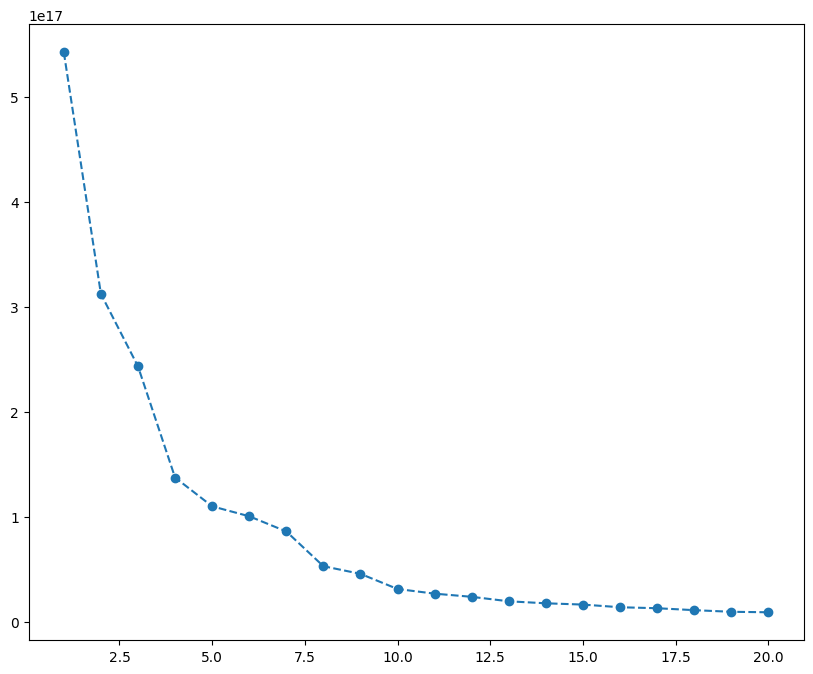

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')

In [ ]:
kmeans_pca = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans_pca.fit(df_cluster_pf)

KMeans(n_clusters=6, random_state=42)

In [ ]:
df_segm_pca_kmeans = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['PC1', 'PC2', 'PC3']
df_segm_pca_kmeans['Grupos'] = kmeans_pca.labels_.astype(str)
#df_segm_pca_kmeans['Grupos'] = clustering.labels_.astype(str)
df_segm_pca_kmeans = df_segm_pca_kmeans.sort_values('Grupos')

In [ ]:
#df_plot = df_segm_pca_kmeans

In [ ]:
#fig, ax = plt.subplots(figsize=(14, 9))
#
#for i, feature in enumerate(features):
#
#    ax.text(
#        loadings[0, i] * 1.1,
#        loadings[1, i] * 1.1,
#        feature,
#        fontsize=15
#    )
#
#    ax.scatter(
#        (df_segm_pca_kmeans['PC1'] - df_segm_pca_kmeans['PC1'].mean()) / df_segm_pca_kmeans['PC1'].std(ddof=1),
#        (df_segm_pca_kmeans['PC2'] - df_segm_pca_kmeans['PC2'].mean()) / df_segm_pca_kmeans['PC2'].std(ddof=1),
#        #alpha=.01
#    )
#
#    ax.arrow(
#        0,
#        0,
#        loadings[0, i],
#        loadings[1, i],
#        )
#
#    #ax.set_xlabel('PC1',
#    #              fontsize=15)
#    #ax.set_ylabel('PC2',
#    #              fontsize=15)

<Axes: xlabel='idade', ylabel='renda_mensal'>

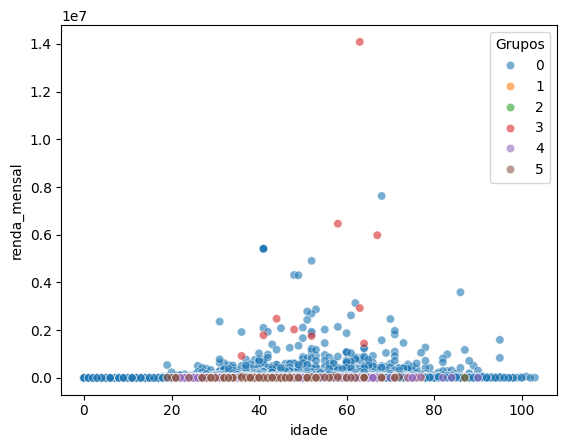

In [ ]:
sns.scatterplot(
    data=df_segm_pca_kmeans,
    x='idade',
    y='renda_mensal',
    alpha=.6,
    hue='Grupos'
)

In [ ]:
teste = df_segm_pca_kmeans\
    .loc[:, 
         ['Grupos'] +
         df_segm_pca_kmeans.columns[
             df_segm_pca_kmeans.columns.str.startswith('prod_')
            ].tolist()
         ]\
    .set_index('Grupos')\
    .stack()\
    .reset_index()\
    .rename(columns={'level_1': 'produto'})\
    .drop(columns=[0])

In [ ]:
teste.groupby(['Grupos', 'produto']).produto.count()

Grupos  produto                
0       prod_adq                   158672
        prod_cambio                158672
        prod_canais                158672
        prod_capital_social        158672
        prod_cartao_credito        158672
                                    ...  
5       prod_seguro_patr              118
        prod_seguro_prestamista       118
        prod_seguro_residencial       118
        prod_seguro_rural             118
        prod_seguro_vida              118
Name: produto, Length: 228, dtype: int64

In [ ]:
#sns.scatterplot(
#    data=df_segm_pca_kmeans,
#    x='PC2',
#    y='PC1',
#    hue='qt_fundos',
#    #palette='renda_mensal'
#)

In [ ]:
#fig = px.scatter_3d(
#    df_segm_pca_kmeans[['PC1', 'PC2', 'PC3']].to_numpy(), x=0, y=1, z=2,
#    color=df_segm_pca_kmeans['Grupos'],
#    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
#)
#fig.show()

<Axes: xlabel='tempo_assoc', ylabel='renda_mensal'>

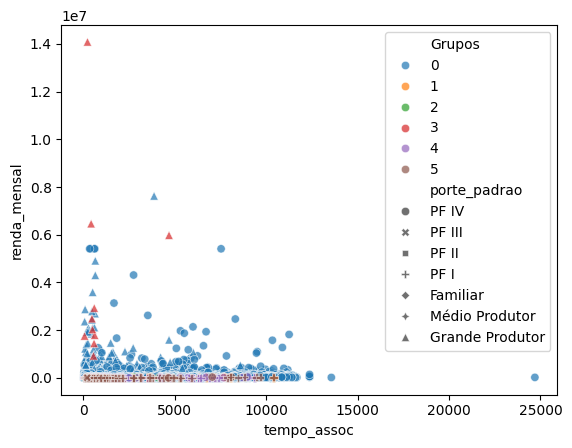

In [ ]:
sns.scatterplot(
    df_segm_pca_kmeans, x='tempo_assoc', y='renda_mensal',
    hue='Grupos',
    style='porte_padrao',
    alpha=.7
)

<Axes: xlabel='tempo_assoc'>

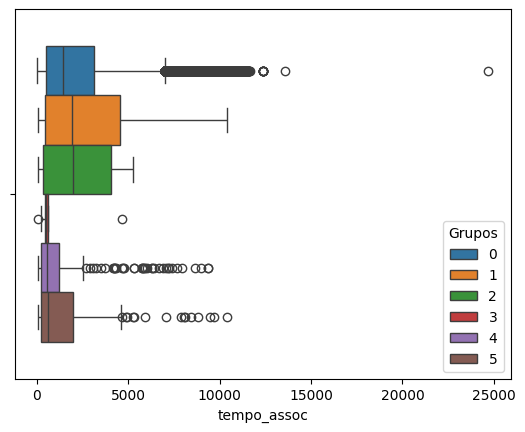

In [ ]:
sns.boxplot(df_segm_pca_kmeans, x="tempo_assoc", hue="Grupos")

<Axes: xlabel='renda_mensal'>

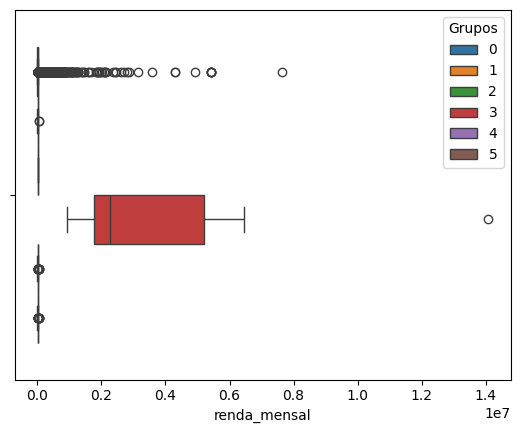

In [ ]:
sns.boxplot(df_segm_pca_kmeans, x="renda_mensal", hue="Grupos")

<Axes: xlabel='score_principalidade'>

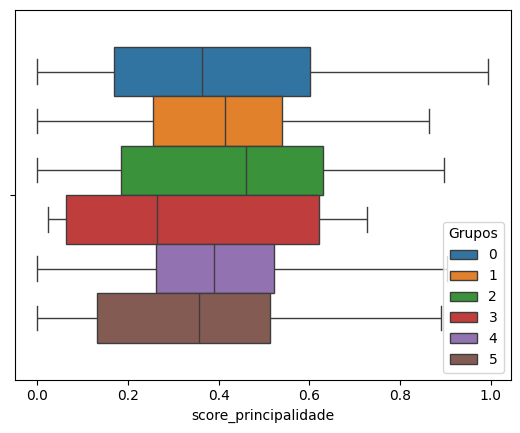

In [ ]:
sns.boxplot(df_segm_pca_kmeans, x="score_principalidade", hue="Grupos")

<Axes: xlabel='idade'>

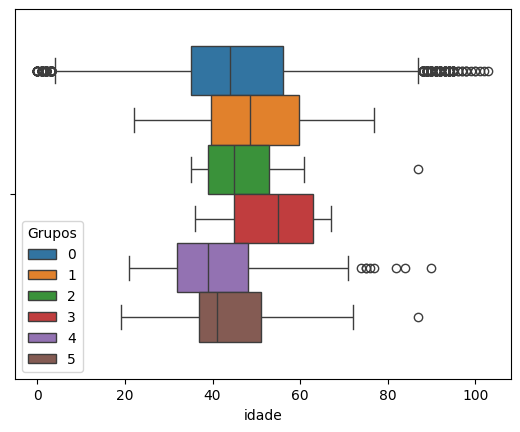

In [ ]:
sns.boxplot(df_segm_pca_kmeans, x="idade", hue="Grupos")

<Axes: xlabel='mc_total'>

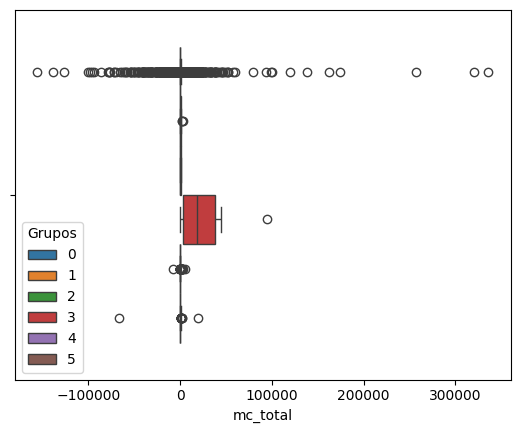

In [ ]:
sns.boxplot(df_segm_pca_kmeans, x="mc_total", hue="Grupos")

In [ ]:
#df_segm_pca_kmeans.to_csv('relacionamento_clusters.csv', index=False)

In [ ]:
#teste = df_segm_pca_kmeans\
#    .reset_index(drop=True)\
#    .set_index(
#        df_segm_pca_kmeans.columns[
#            ~df_segm_pca_kmeans.columns.str.startswith('prod_')
#        ].tolist()
#    )\
#    .stack()\
#    .to_frame()\
#    .reset_index()
#
#teste.to_csv('relacionamento_clusters2.csv', index=False)